## Identifying safe loans with decision trees
The LendingClub is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default. In this assignment you will:

Use SFrames to do some feature engineering. Train a decision-tree on the LendingClub dataset. Visualize the tree. Predict whether a loan will default along with prediction probabilities (on a validation set). Train a complex tree model and compare it to simple tree model.

Load the Lending Club dataset

In [1]:
import pandas as pd
import numpy as np
import json

def readjson(path):
    try:
        with open(path,'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError( "Please check the path and try agaian!!!")

In [2]:
loans = pd.read_csv('lending-club-data.csv')


/anaconda3/envs/AI-ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [4]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### Exploring the target column
The target column (label column) of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

+1 as a safe loan -1 as a risky (bad) loan

In [5]:
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)

Now, let us explore the distribution of the column safe_loans. This gives us a sense of how many safe and risky loans are present in the dataset. Print out the percentage of safe loans and risky loans in the data frame.

You should have:

Around 81% safe loans Around 19% risky loans It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

In [6]:
safe_loans_prob = round(float(sum(loans['safe_loans'] == 1))/len(loans),2)

In [7]:
safe_loans_prob

0.81

### Features for the classification algorithm
In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features. Extract these feature columns and target column from the dataset. We will only use these features.

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

### One-hot encoding

In [9]:
loans.fillna('N/A')
for i in loans.index:
    for j in loans.columns:
        x = loans.at[i, j]
        if isinstance(x, str):
            x = x.strip().lower()
            loans.at[i, j] = x

loans = pd.get_dummies(loans)

In [10]:
loans.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_a', 'grade_b', 'grade_c', 'grade_d', 'grade_e',
       'grade_f', 'grade_g', 'sub_grade_a1', 'sub_grade_a2', 'sub_grade_a3',
       'sub_grade_a4', 'sub_grade_a5', 'sub_grade_b1', 'sub_grade_b2',
       'sub_grade_b3', 'sub_grade_b4', 'sub_grade_b5', 'sub_grade_c1',
       'sub_grade_c2', 'sub_grade_c3', 'sub_grade_c4', 'sub_grade_c5',
       'sub_grade_d1', 'sub_grade_d2', 'sub_grade_d3', 'sub_grade_d4',
       'sub_grade_d5', 'sub_grade_e1', 'sub_grade_e2', 'sub_grade_e3',
       'sub_grade_e4', 'sub_grade_e5', 'sub_grade_f1', 'sub_grade_f2',
       'sub_grade_f3', 'sub_grade_f4', 'sub_grade_f5', 'sub_grade_g1',
       'sub_grade_g2', 'sub_grade_g3', 'sub_grade_g4', 'sub_grade_g5',
       'home_ownership_mortgage', 'home_ownership_other', 'home_ownership_own',
       'home_ownership_rent', 'purpose_car', 'purpose_credit_card'

In [11]:
train_idx = readjson('module-5-assignment-1-train-idx.json')
validation_idx = readjson('module-5-assignment-1-validation-idx.json')

In [12]:
train_data = loans.iloc[train_idx].copy(deep=True)
validation_data = loans.iloc[validation_idx].copy(deep=True)

In [13]:
train_data.shape

(37224, 68)

In [14]:
validation_data.shape

(9284, 68)

In [15]:
safe_loans_prob = round(float(sum(validation_data['safe_loans'] == 1))/len(validation_data),2)
safe_loans_prob

0.5

### Build a decision tree classifier

Now, let's use the built-in scikit learn decision tree learner (sklearn.tree.DecisionTreeClassifier) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

Note: You will have to first convert the SFrame into a numpy data matrix, and extract the target labels as a numpy array (Hint: you can use the .to_numpy() method call on SFrame to turn SFrames into numpy arrays). See the API for more information. Make sure to set max_depth=6.

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [17]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=6)
x = train_data.drop('safe_loans',1)
decision_tree_model.fit(x, train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
small_model = tree.DecisionTreeClassifier(max_depth=2)
small_model.fit(train_data.drop('safe_loans',1), train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Visualizing a learned model

In [19]:
tree.export_graphviz(small_model, out_file='tree.dot')

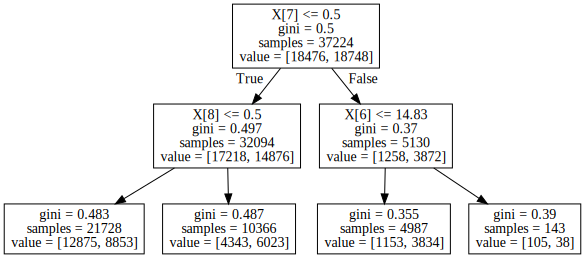

In [25]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(small_model, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Making predictions
Let's consider two positive and two negative examples from the validation set and see what the model predicts. We will do the following:

Predict whether or not a loan is safe. Predict the probability that a loan is safe.

First, let's grab 2 positive examples and 2 negative examples.

In [26]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_a,grade_b,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


Now, we will use our model to predict whether or not a loan is likely to default. For each row in the sample_validation_data, use the decision_tree_model to predict whether or not the loan is classified as a safe loan. (Hint: if you are using scikit-learn, you can use the .predict() method)

**Quiz Question: What percentage of the predictions on sample_validation_data did decision_tree_model get correct?**

In [27]:
decision_tree_model.predict(sample_validation_data.drop('safe_loans',1))

array([ 1, -1, -1,  1])

### Explore probability predictions
For each row in the sample_validation_data, what is the probability (according decision_tree_model) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

**Quiz Question: Which loan has the highest probability of being classified as a safe loan?**

In [28]:
decision_tree_model.predict_proba(sample_validation_data.drop('safe_loans',1))

array([[0.34156543, 0.65843457],
       [0.53630646, 0.46369354],
       [0.64750958, 0.35249042],
       [0.20789474, 0.79210526]])

### Tricky predictions!
Now, we will explore something pretty interesting. For each row in the sample_validation_data, what is the probability (according to small_model) of a loan being classified as safe?

In [29]:
small_model.predict_proba(sample_validation_data.drop('safe_loans',1))

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

### Visualize the prediction on a tree
**Quiz Question: Based on the visualized tree, what prediction would you make for this data point (according to small_model)? (If you don't have Graphviz, you can answer this quiz question by executing the next part.)**

In [30]:
small_model.predict(sample_validation_data.drop('safe_loans',1))

array([ 1, -1, -1,  1])

In [35]:
small_model.predict(sample_validation_data.iloc[1:2].drop('safe_loans',1))

array([-1])

In [36]:
sample_validation_data.iloc[1:2]

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_a,grade_b,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Evaluating accuracy of the decision tree model
Evaluate the accuracy of small_model and decision_tree_model on the training data. (Hint: if you are using scikit-learn, you can use the .score() method)

In [37]:
decision_tree_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None)

0.6405276165914464

In [38]:
small_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None)

0.6135020416935311

Now, evaluate the accuracy of the small_model and decision_tree_model on the entire validation_data, not just the subsample considered above.

In [39]:
decision_tree_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None)

0.6363636363636364

In [40]:
small_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None)

0.6193451098664369

### Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with max_depth=10. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [41]:
big_model = tree.DecisionTreeClassifier(max_depth=10)
big_model.fit(x, train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [42]:
big_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None)

0.6637921770900495

In [43]:
big_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None)

0.6263464024127531

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost each mistake made by the model. Assume the following:

False negatives: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of loosing a loan that would have otherwise been accepted.

False positives: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given.

Correct predictions: All correct predictions don't typically incur any cost.

Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:

First, let us compute the predictions made by the model. Second, compute the number of false positives. Third, compute the number of false negatives. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positves.

Quiz Question: Let's assume that each mistake costs us money: a false negative costs $10,000, while a false positive positive costs $20,000. What is the total cost of mistakes made by decision_tree_model on validation_data?

In [44]:
validation_prediction = decision_tree_model.predict(validation_data.drop('safe_loans',1))

In [45]:
false_negative_counts = sum(validation_prediction < validation_data[target])

In [49]:
false_negative_counts

1715

In [46]:
false_positive_counts = sum(validation_prediction > validation_data[target])

In [50]:
false_positive_counts

1661

In [47]:
total_cost = 10000*false_negative_counts + 20000*false_positive_counts

In [48]:
total_cost

50370000